# Check Neural Collapse in Standard Training

In [1]:
from jaxl.constants import *
from jaxl.datasets.mnist import construct_mnist
from jaxl.datasets.wrappers import (
    ContextDataset,
    StandardSupervisedDataset,
    FixedLengthContextDataset,
    StratifiedContextDataset,
)
from jaxl.models import get_model
from jaxl.models.common import get_activation
from jaxl.models.modules import CNNModule, MLPModule
from jaxl.plot_utils import set_size
from jaxl.utils import parse_dict, get_device

import _pickle as pickle
import argparse
import jax
import jax.random as jrandom
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import torchvision.datasets as torch_datasets

from collections import OrderedDict
from functools import partial
from orbax.checkpoint import PyTreeCheckpointer, CheckpointManager
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from types import SimpleNamespace

In [2]:
# device = "cpu"
device = "gpu:2"
get_device(device)

In [3]:
doc_width_pt = 750.0
mnist_path = "/home/bryanpu1/projects/jaxl/"

# learner_path = "/Users/chanb/research/personal/jaxl/{}".format(
#     "jaxl/logs/icl-mnist/context_len_16-num_blocks_8-01-22-24_23_44_06-92243c9f-bd13-4f61-adef-b73ac5fdbc2e"
# )
learner_path = "/home/bryanpu1/projects/jaxl/{}".format(
    # "jaxl/logs/icl-mnist/context_len_16-num_blocks_8-01-25-24_14_43_17-c7291ffc-8ce2-4765-a6b7-452a095e7c53", # No permutation on label as tasks
    # "jaxl/logs/icl-mnist/context_len_16-num_blocks_8-random_label-01-25-24_17_03_48-49d56e3a-5702-4b5a-b7e5-d6fbcc9153ff", # Trained for 10k epochs, with bs = 128
    "jaxl/logs/icl-mnist/context_len_16-num_blocks_8-fixed_length-random_label-01-26-24_13_12_58-969855a4-434e-4acf-b4b3-58bff7006a67" # Trained for 5k epochs, with bs = 32, full-context length
)

exp_name = "-".join(learner_path.split("/")[-1].split("-")[:-8])

# Load Model

In [4]:
def load_model(learner_path: str):
    config_path = os.path.join(learner_path, "config.json")
    with open(config_path, "r") as f:
        config_dict = json.load(f)
        config = parse_dict(config_dict)

    model = get_model((1, 28, 28), (10,), config.model_config)

    checkpoint_manager = CheckpointManager(
        os.path.join(learner_path, "models"),
        PyTreeCheckpointer(),
    )

    params = checkpoint_manager.restore(checkpoint_manager.latest_step())
    params[CONST_MODEL_DICT][CONST_MODEL][CONST_POSITIONAL_ENCODING] = dict()

    return params, model, config

In [5]:
params, model, config = load_model(learner_path)

/home/bryanpu1/.conda/envs/jaxl_cudnn12/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1472: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs.
  warnings.warn(


# Run Config

In [6]:
config

namespace(logging_config=namespace(save_path='./logs/icl-mnist',
                                   experiment_name='context_len_16-num_blocks_8-fixed_length-random_label',
                                   log_interval=10,
                                   checkpoint_interval=100),
          model_config=namespace(architecture='icl_gpt',
                                 num_contexts=16,
                                 num_blocks=8,
                                 num_heads=1,
                                 embed_dim=32,
                                 positional_encoding=namespace(type='default',
                                                               kwargs=namespace(embed_dim=32,
                                                                                max_len=17)),
                                 input_tokenizer=namespace(type='cnn',
                                                           kwargs=namespace(features=[32,
                                       

# Helper Function

In [7]:
def get_preds_labels(data_loader, num_tasks):
    all_preds = []
    all_labels = []
    all_outputs = []

    for batch_i, samples in enumerate(data_loader):
        if batch_i >= num_tasks:
            break

        (context_inputs, context_outputs, queries, one_hot_labels) = samples
        
        outputs, _ = model.forward(
            params[CONST_MODEL_DICT][CONST_MODEL],
            queries.numpy(),
            {
                CONST_CONTEXT_INPUT: context_inputs.numpy(),
                CONST_CONTEXT_OUTPUT: context_outputs.numpy(),
            }
        )
        preds = np.argmax(outputs, axis=-1)
        labels = np.argmax(one_hot_labels, axis=-1)
        all_preds.append(preds)
        all_labels.append(labels)
        all_outputs.append(outputs)

    all_outputs = np.concatenate(all_outputs)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_preds, all_labels, all_outputs


def print_performance(all_preds, all_labels, sequence_length, context_len, output_dim, fixed_length):
    conf_mat = confusion_matrix(all_labels, all_preds, labels=np.arange(output_dim))
    acc = np.trace(conf_mat) / np.sum(conf_mat) * 100
    print("Pretraining Accuracy: {}".format(acc))

    if not fixed_length:
        reshaped_preds = all_preds.reshape((-1, sequence_length - 1))
        reshaped_labels = all_labels.reshape((-1, sequence_length - 1))
        for curr_context_len in range(context_len):
            if curr_context_len < context_len - 1:
                curr_preds = reshaped_preds[:, curr_context_len]
                curr_labels = reshaped_labels[:, curr_context_len]
            else:
                curr_preds = reshaped_preds[:, curr_context_len:]
                curr_labels = reshaped_labels[:, curr_context_len:]

            curr_preds = curr_preds.reshape(-1)
            curr_labels = curr_labels.reshape(-1)

            curr_conf_mat = confusion_matrix(curr_labels, curr_preds, labels=np.arange(output_dim))
            curr_acc = np.trace(curr_conf_mat) / np.sum(curr_conf_mat) * 100
            print("Pretraining Accuracy with Context Length {} (Num Samples: {}): {}".format(curr_context_len + 1, np.sum(curr_conf_mat), curr_acc))

# Train Dataset

In [8]:
num_tasks = 10000
context_len = config.learner_config.dataset_config.dataset_wrapper.kwargs.context_len
sequence_length = config.learner_config.dataset_config.dataset_kwargs.task_config.sequence_length

In [9]:
if config.learner_config.dataset_config.dataset_wrapper.type == "ContextDataset":
    wrapper = ContextDataset
    fixed_length = False
elif config.learner_config.dataset_config.dataset_wrapper.type == "FixedLengthContextDataset":
    wrapper = FixedLengthContextDataset
    fixed_length = True
else:
    raise ValueError("Invalid Wrapper")

train_dataset = wrapper(
    construct_mnist(
        save_path=config.learner_config.dataset_config.dataset_kwargs.save_path,
        task_name=config.learner_config.dataset_config.dataset_kwargs.task_name,
        task_config=config.learner_config.dataset_config.dataset_kwargs.task_config,
        train=True,
    ),
    context_len=config.learner_config.dataset_config.dataset_wrapper.kwargs.context_len,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=train_dataset._dataset.sequence_length - 1,
    shuffle=False,
    drop_last=False,
    num_workers=4,
)

Loading from /home/bryanpu1/projects/jaxl/data/icl-mnist-seq_len_30-500k_tasks-train-random_label.pkl


## Check Dataset

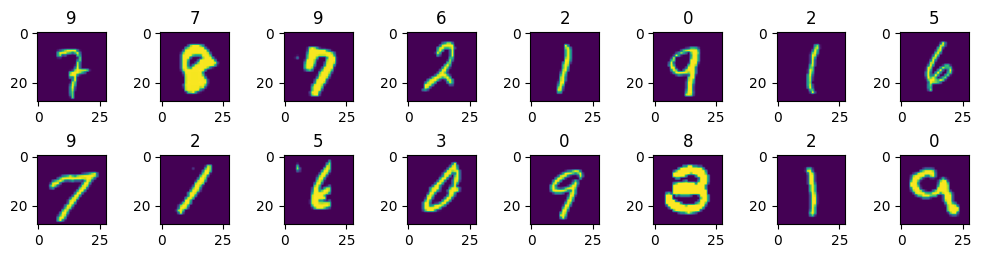

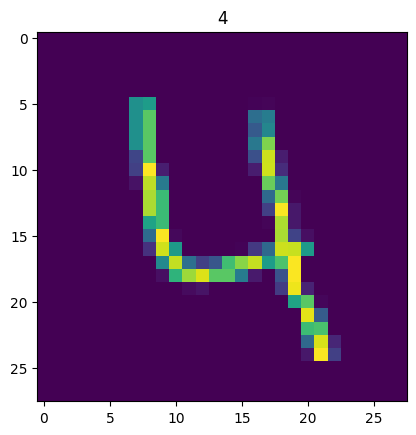

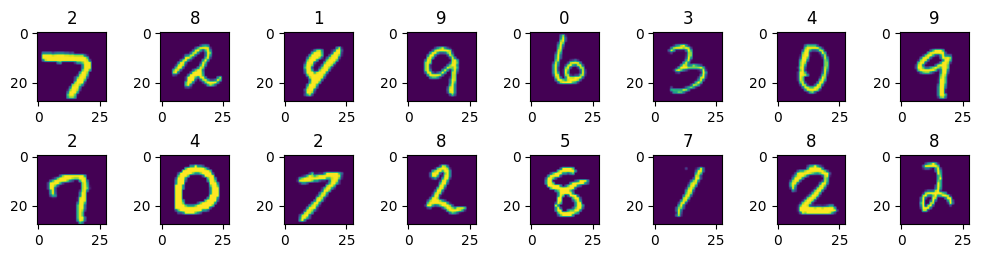

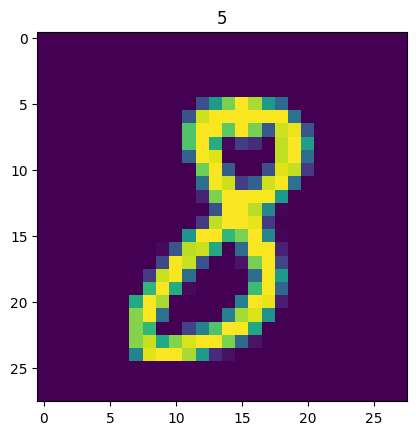

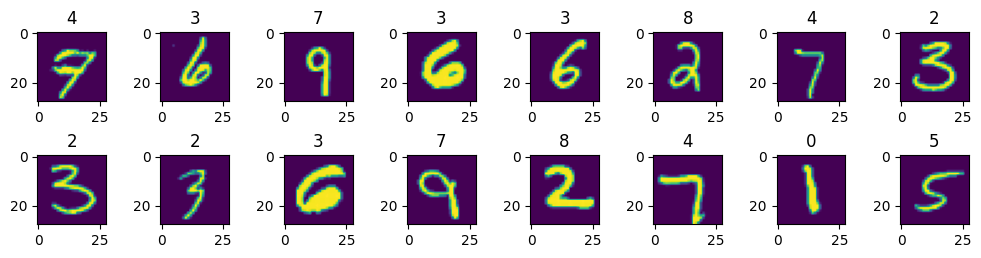

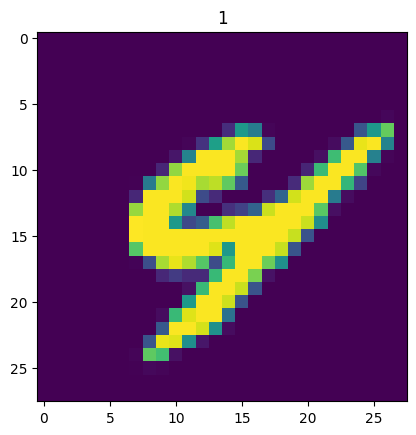

In [10]:
for task_i in range(2):
    ci, co, q, l = train_dataset[task_i * 29 + 28]

    nrows = 2
    ncols = 8
    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=set_size(doc_width_pt, 0.95, (nrows, ncols), False),
        layout="constrained",
    )

    for idx, (img, label) in enumerate(zip(ci, co)):
        axes[idx // ncols, idx % ncols].imshow(img)
        axes[idx // ncols, idx % ncols].set_title(np.argmax(label))
    plt.show()
    plt.close()

    plt.imshow(q.numpy()[0])
    plt.title(np.argmax(l))
    plt.show()
    plt.close()


# Train Performance

In [11]:
all_preds, all_labels, all_outputs = get_preds_labels(train_loader, num_tasks)
print_performance(all_preds, all_labels, sequence_length, context_len, train_dataset.output_dim[0], fixed_length)

Pretraining Accuracy: 10.053448275862069


In [12]:
np.unique(all_preds)

array([6], dtype=int32)

## Full Context Length

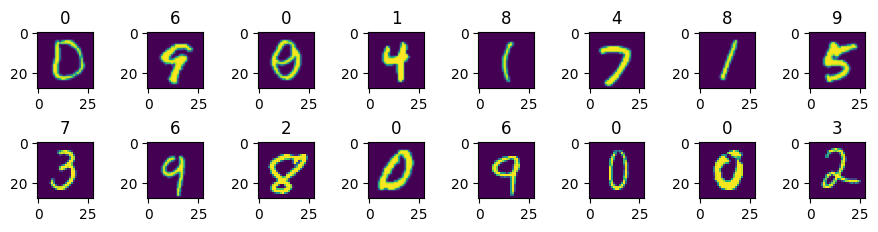

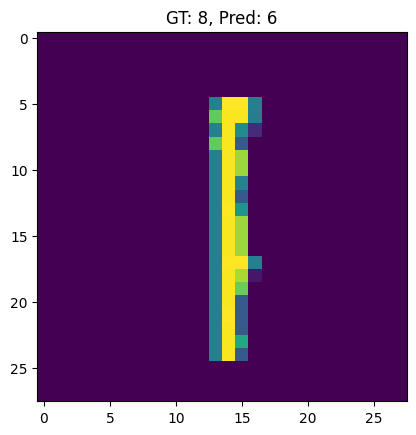

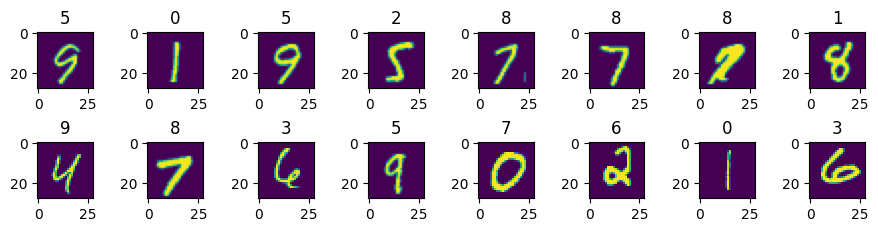

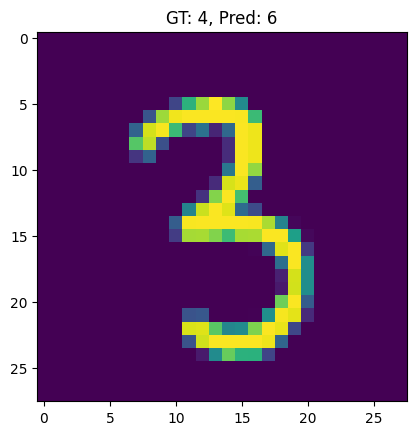

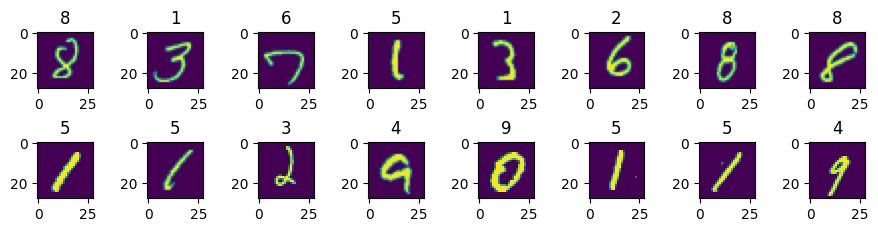

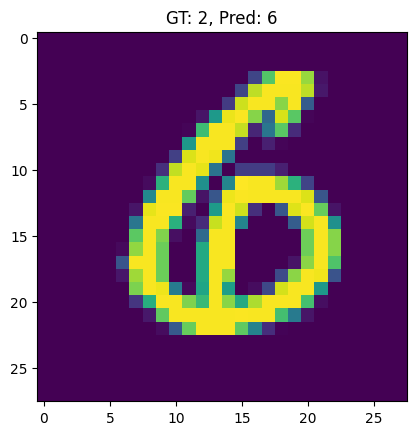

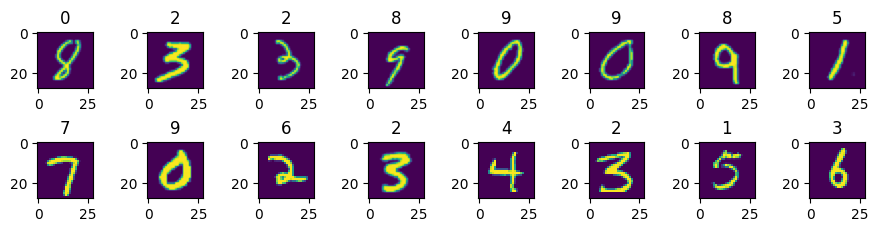

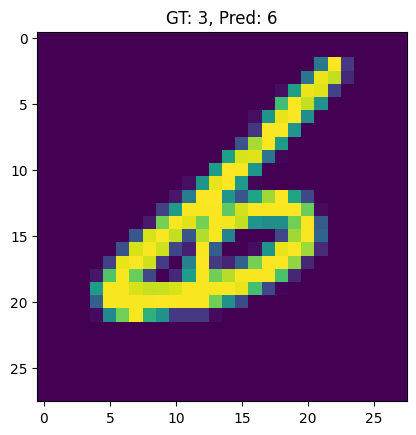

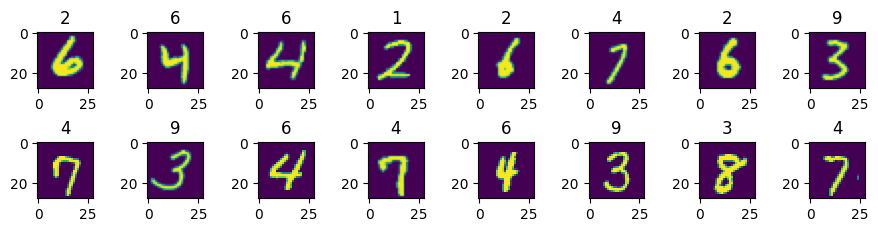

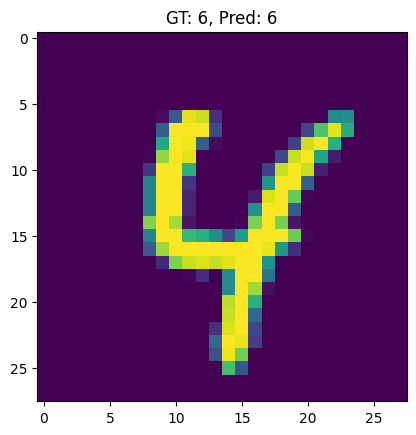

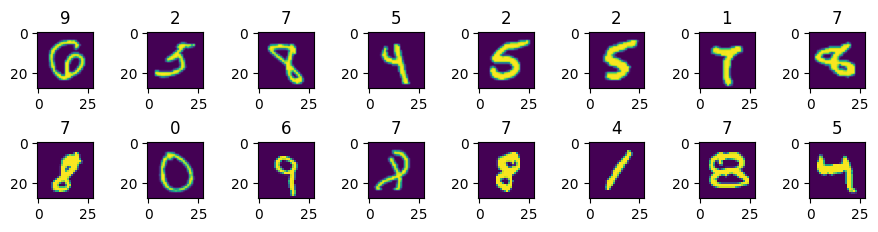

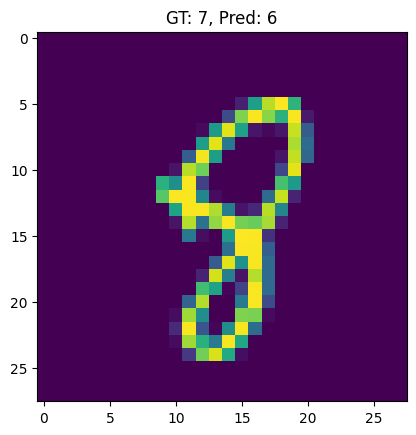

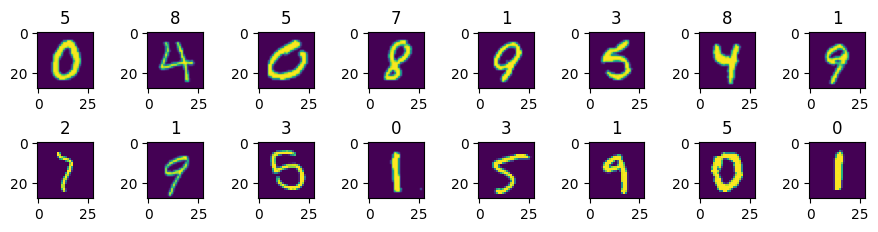

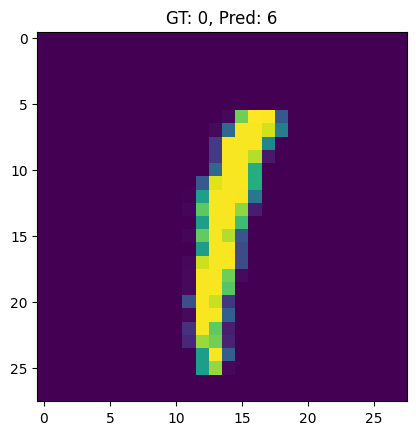

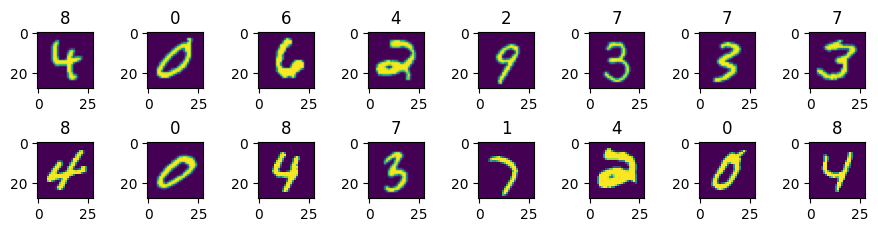

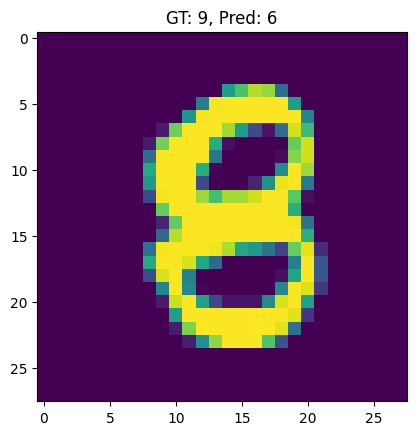

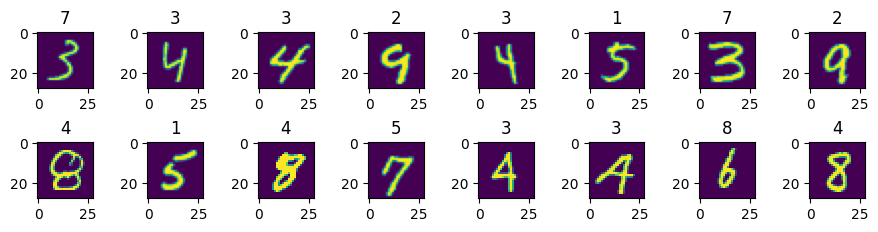

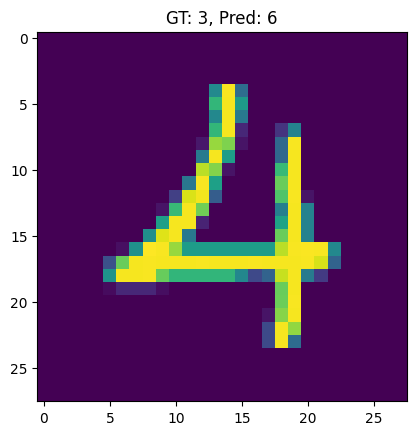

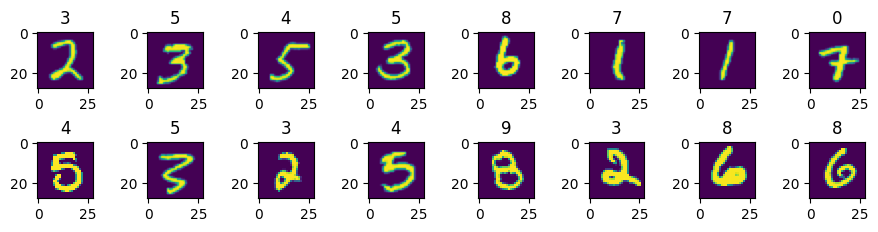

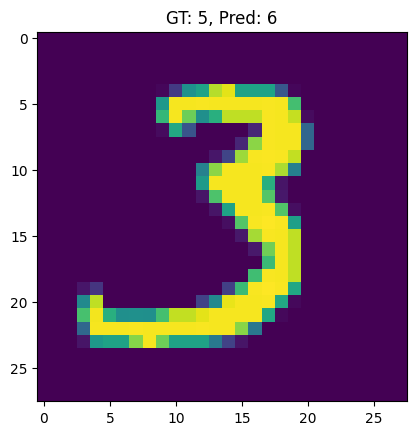

In [13]:
start_task = 200
num_tasks_to_plot = 10

for task_i in range(num_tasks_to_plot):
    sample_idx = (task_i + start_task) * (sequence_length - 1) + sequence_length - 2
    imgs, outputs, query, label = train_dataset[sample_idx]

    nrows = 2
    ncols = context_len // nrows
    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=set_size(doc_width_pt, 0.85, (nrows, ncols), False),
        layout="constrained",
    )

    for idx, (img, output) in enumerate(zip(imgs, outputs)):
        axes[idx // ncols, idx % ncols].imshow(img)
        axes[idx // ncols, idx % ncols].set_title(np.argmax(output))
    plt.show()
    plt.close()

    plt.imshow(query.numpy()[0])
    plt.title("GT: {}, Pred: {}".format(np.argmax(label), all_preds[sample_idx]))
    plt.show()
    plt.close()


## Context Length = 1

In [14]:
if not fixed_length:
    start_task = 200
    num_tasks_to_plot = 10

    ncols = 5
    nrows = num_tasks_to_plot // ncols
    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=set_size(doc_width_pt, 0.95, (nrows, ncols), False),
        layout="constrained",
    )

    for task_i in range(num_tasks_to_plot):
        imgs, outputs, _, _ = train_dataset[(task_i + start_task) * (sequence_length - 1)]
        axes[task_i // ncols, task_i % ncols].imshow(imgs[-1])
        axes[task_i // ncols, task_i % ncols].set_title("Perm: {}, GT: {}, Pred: {}".format(
            np.argmax(outputs[-1]),
            all_labels[(task_i + start_task) * (sequence_length - 1)],
            all_preds[(task_i + start_task) * (sequence_length - 1)])
        )

    plt.show()
    plt.close()


# Test Performance on Standard MNIST

In [15]:
test_dataset = FixedLengthContextDataset(
    construct_mnist(
        save_path=config.learner_config.dataset_config.dataset_kwargs.save_path,
        task_name=config.learner_config.dataset_config.dataset_kwargs.task_name,
        task_config=parse_dict({
            "num_sequences": 500000,
            "sequence_length": 30,
            "random_label": False,
            "save_path": "/home/bryanpu1/projects/jaxl/data/icl-mnist-seq_len_30-500k_tasks-test.pkl"
        }),
        train=False,
    ),
    context_len=config.learner_config.dataset_config.dataset_wrapper.kwargs.context_len,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=test_dataset._dataset.sequence_length - 1,
    shuffle=False,
    drop_last=False,
    num_workers=4,
)

Loading from /home/bryanpu1/projects/jaxl/data/icl-mnist-seq_len_30-500k_tasks-test.pkl


In [16]:
all_preds, all_labels, all_outputs = get_preds_labels(test_loader, num_tasks)
print_performance(all_preds, all_labels, sequence_length, context_len, test_dataset.output_dim[0], True)

Pretraining Accuracy: 9.540689655172415


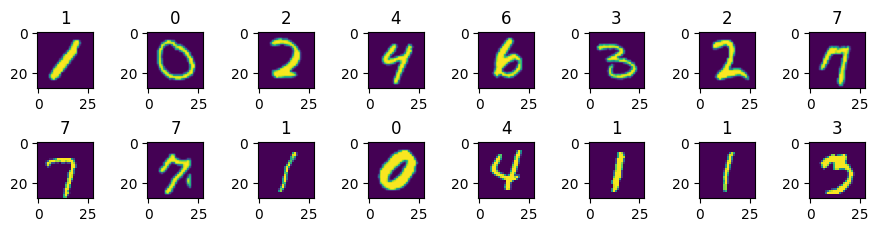

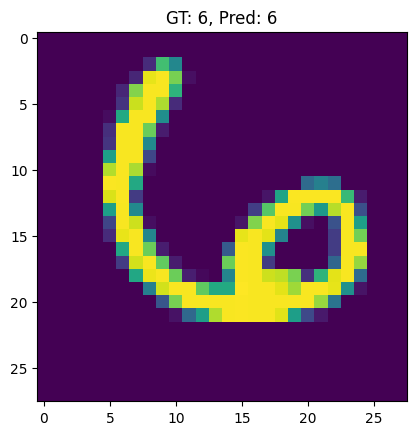

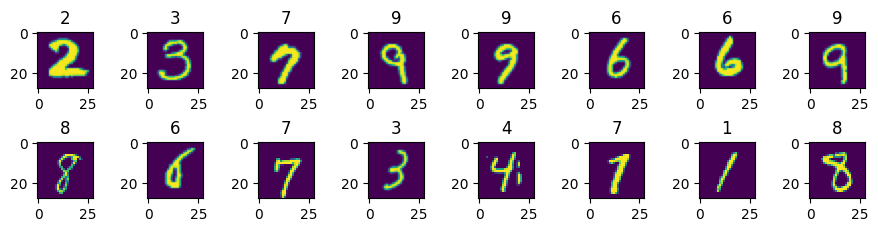

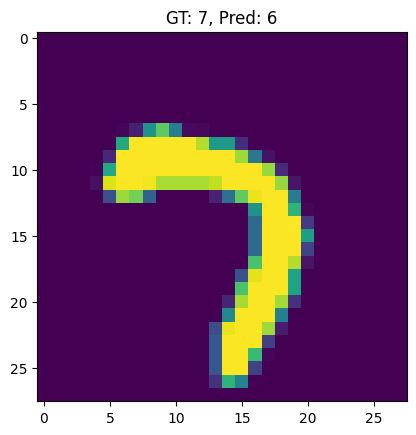

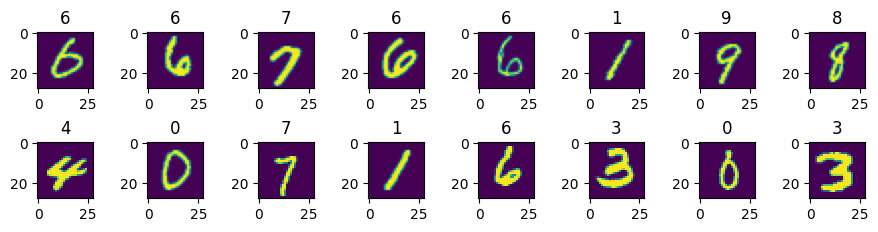

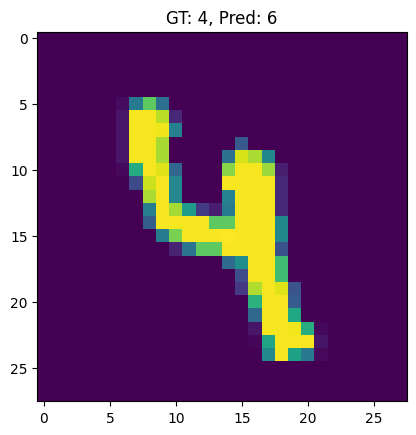

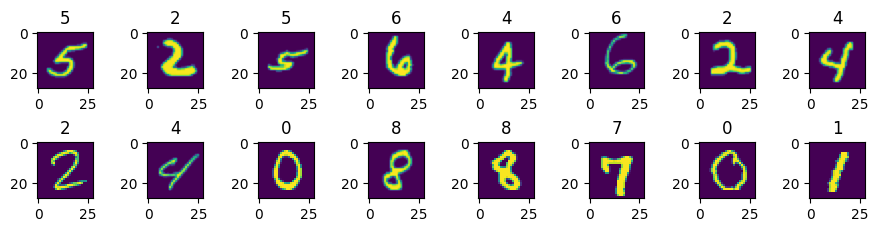

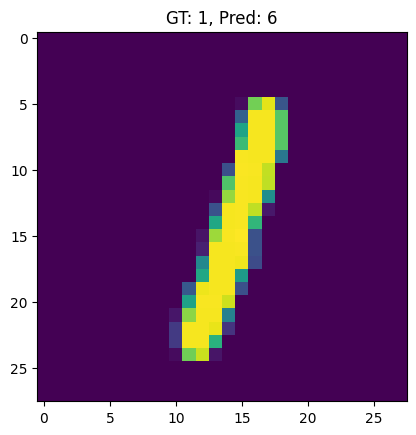

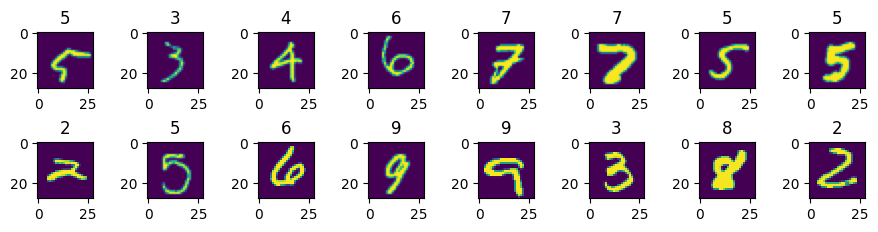

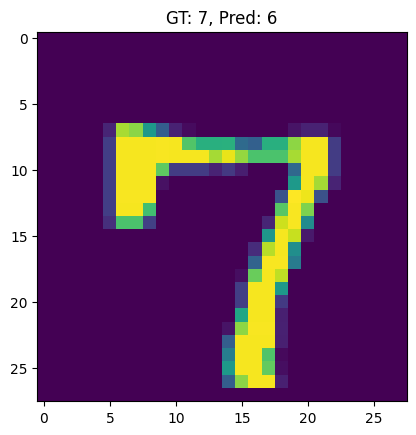

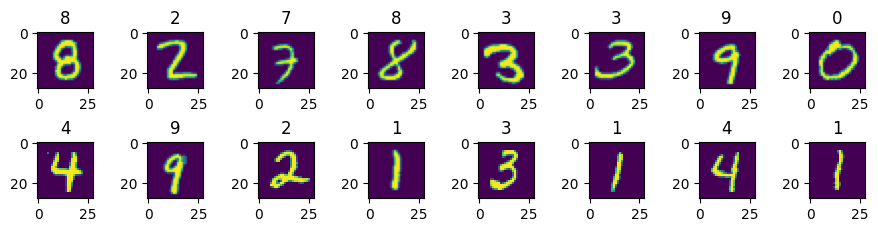

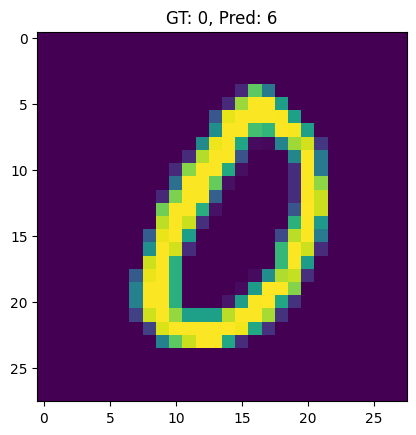

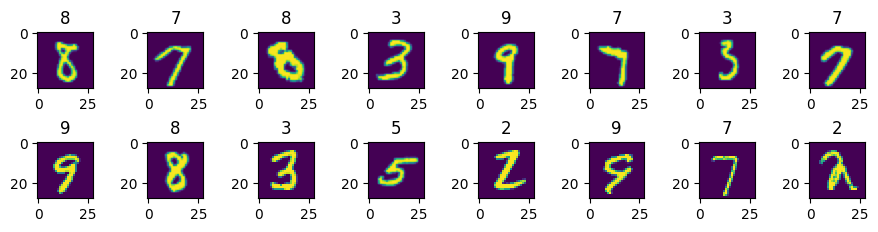

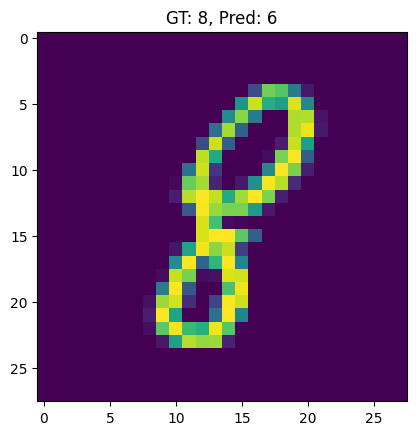

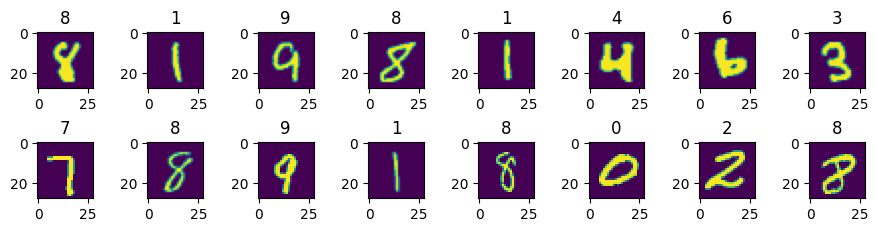

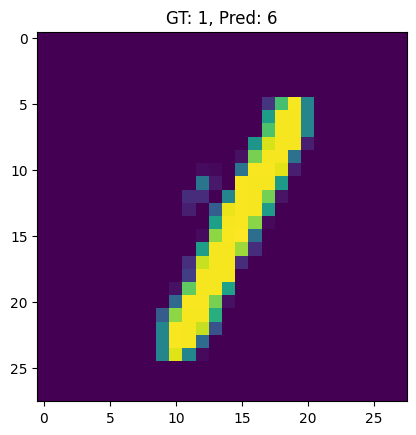

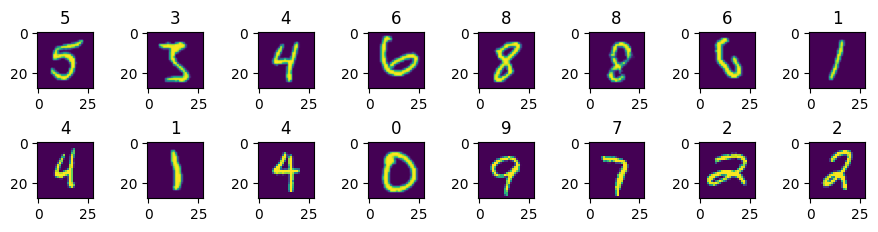

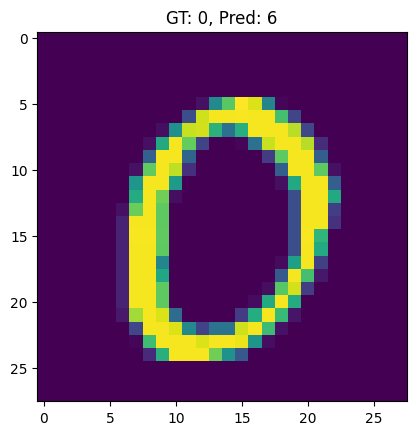

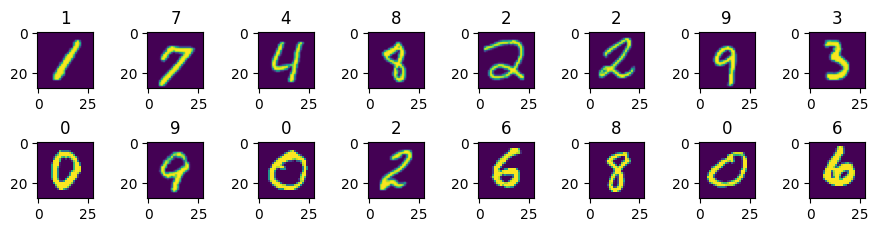

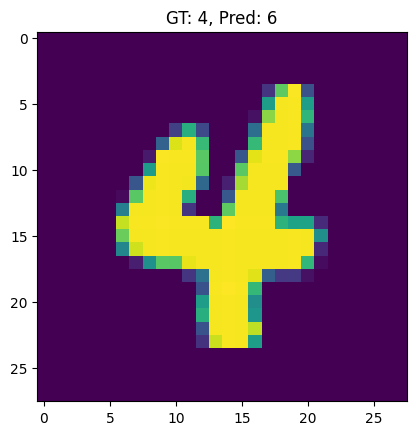

In [17]:
start_task = 200
num_tasks_to_plot = 10

for task_i in range(num_tasks_to_plot):
    sample_idx = (task_i + start_task) * (sequence_length - 1) + sequence_length - 2
    imgs, outputs, query, label = test_dataset[sample_idx]

    nrows = 2
    ncols = context_len // nrows
    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=set_size(doc_width_pt, 0.85, (nrows, ncols), False),
        layout="constrained",
    )

    for idx, (img, output) in enumerate(zip(imgs, outputs)):
        axes[idx // ncols, idx % ncols].imshow(img)
        axes[idx // ncols, idx % ncols].set_title(np.argmax(output))
    plt.show()
    plt.close()

    plt.imshow(query.numpy()[0])
    plt.title("GT: {}, Pred: {}".format(np.argmax(label), all_preds[sample_idx]))
    plt.show()
    plt.close()


# Test Performance on Random Label

In [18]:
test_dataset = wrapper(
    construct_mnist(
        save_path=config.learner_config.dataset_config.dataset_kwargs.save_path,
        task_name=config.learner_config.dataset_config.dataset_kwargs.task_name,
        task_config=parse_dict({
            "num_sequences": 500000,
            "sequence_length": 30,
            "random_label": True,
            "save_path": '/home/bryanpu1/projects/jaxl/jaxl/data/icl-mnist-seq_len_30-500k_tasks-test-random_label.pkl'
        }),
        train=False,
    ),
    context_len=config.learner_config.dataset_config.dataset_wrapper.kwargs.context_len,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=test_dataset._dataset.sequence_length - 1,
    shuffle=False,
    drop_last=False,
    num_workers=4,
)

Loading from /home/bryanpu1/projects/jaxl/jaxl/data/icl-mnist-seq_len_30-500k_tasks-test-random_label.pkl


In [19]:
all_preds, all_labels, _ = get_preds_labels(test_loader, num_tasks)
print_performance(all_preds, all_labels, sequence_length, context_len, test_dataset.output_dim[0], fixed_length=fixed_length)

Pretraining Accuracy: 10.026206896551724


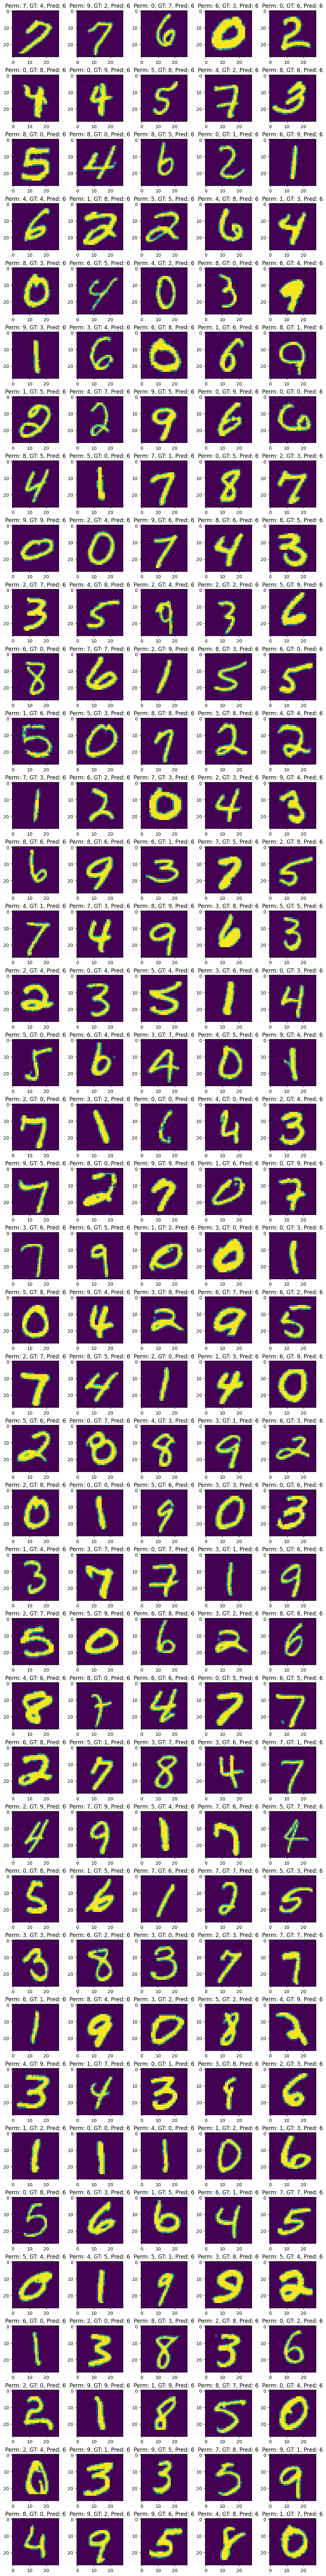

In [20]:
ncols = 5
nrows = 200 // ncols
fig, axes = plt.subplots(
    nrows,
    ncols,
    figsize=set_size(doc_width_pt, 0.95, (nrows, ncols), False),
    layout="constrained",
)

start_task = 0
for task_i in range(200):
    imgs, outputs, _, _ = test_dataset[(task_i + start_task) * (sequence_length - 1)]
    axes[task_i // ncols, task_i % ncols].imshow(imgs[-1])
    axes[task_i // ncols, task_i % ncols].set_title("Perm: {}, GT: {}, Pred: {}".format(
        np.argmax(outputs[-1]),
        all_labels[(task_i + start_task) * (sequence_length - 1)],
        all_preds[(task_i + start_task) * (sequence_length - 1)])
    )

plt.show()
plt.close()


# Random Binary Partition

In [21]:
test_dataset = wrapper(
    construct_mnist(
        save_path=config.learner_config.dataset_config.dataset_kwargs.save_path,
        task_name=CONST_MULTITASK_MNIST_RANDOM_BINARY,
        task_config=parse_dict({
            "num_sequences": 500000,
            "sequence_length": 30,
            "save_path": '/home/bryanpu1/projects/jaxl/jaxl/data/icl-mnist-seq_len_30-500k_tasks-test-random_binary.pkl'
        }),
        train=False,
    ),
    context_len=config.learner_config.dataset_config.dataset_wrapper.kwargs.context_len,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=test_dataset._dataset.sequence_length - 1,
    shuffle=False,
    drop_last=False,
    num_workers=4,
)

Loading from /home/bryanpu1/projects/jaxl/jaxl/data/icl-mnist-seq_len_30-500k_tasks-test-random_binary.pkl


In [22]:
all_preds, all_labels, _ = get_preds_labels(test_loader, num_tasks)
print_performance(all_preds, all_labels, sequence_length, context_len, test_dataset.output_dim[0], fixed_length=fixed_length)

Pretraining Accuracy: 0.0


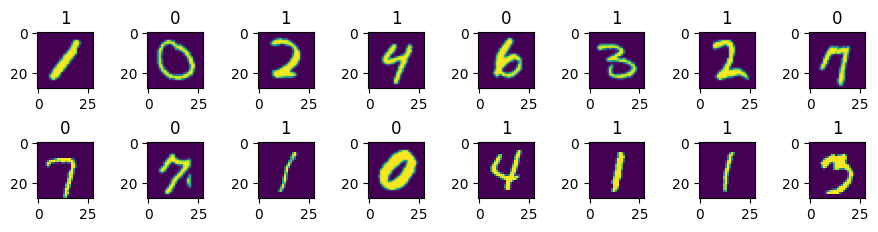

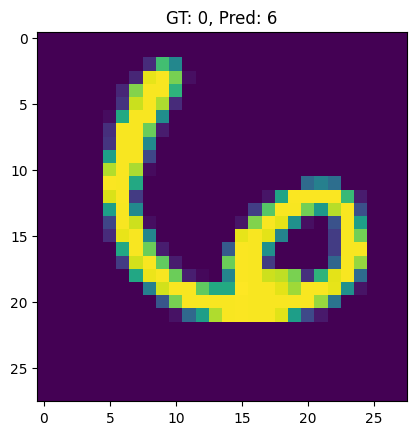

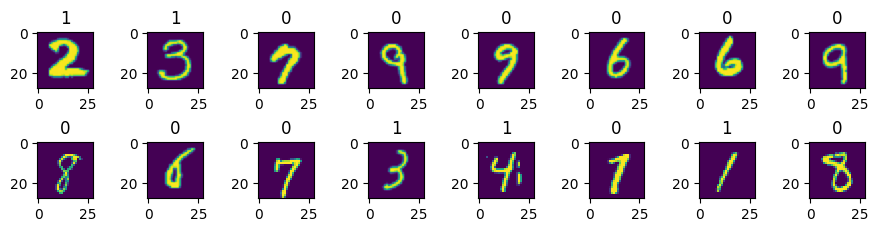

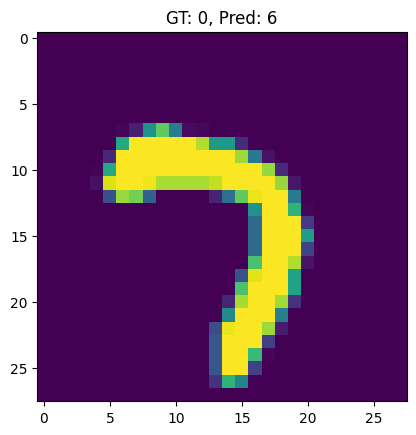

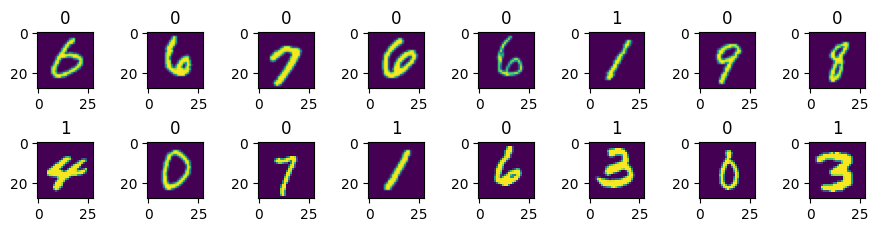

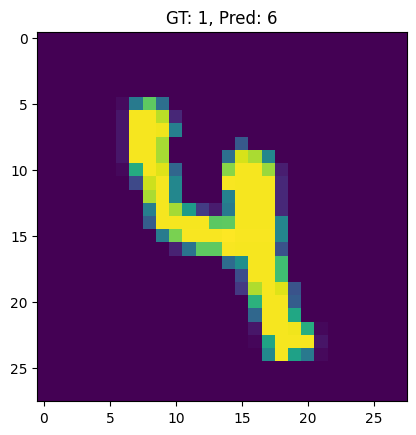

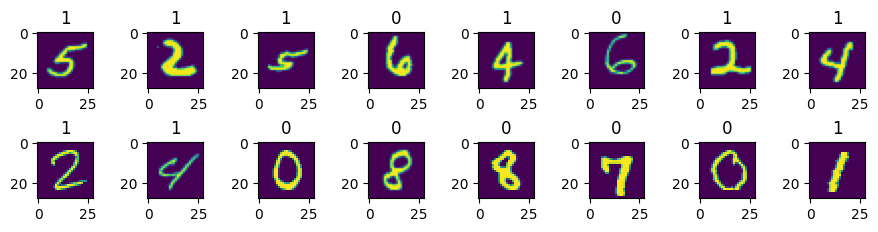

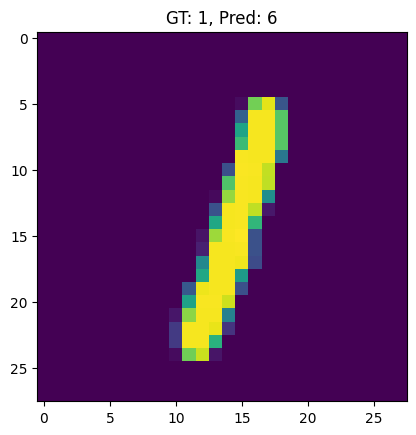

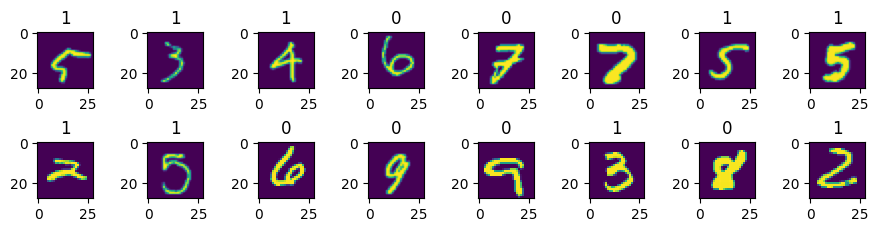

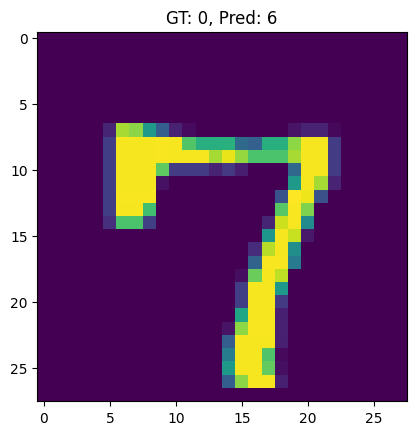

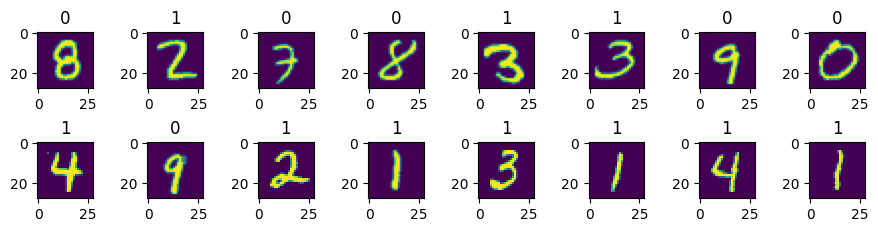

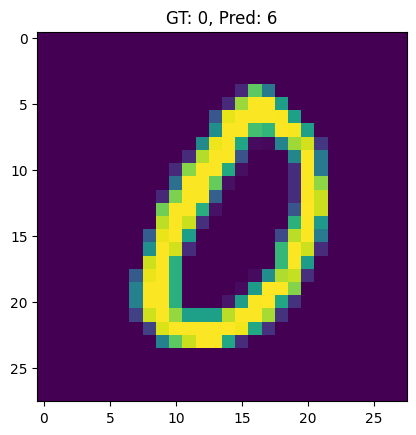

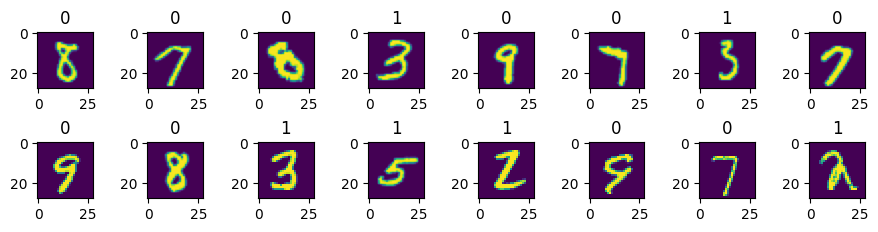

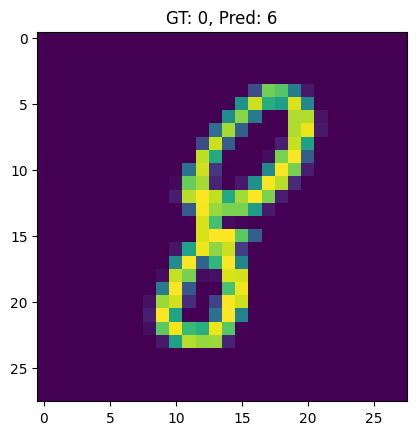

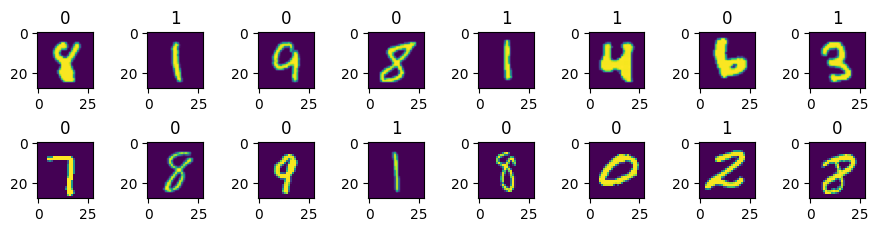

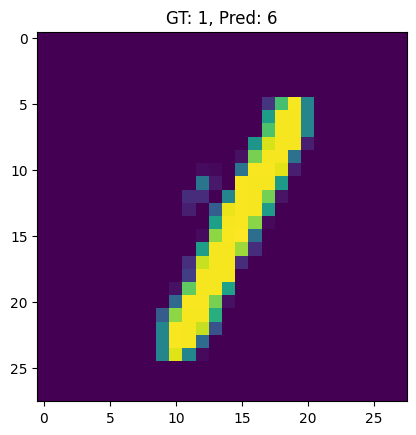

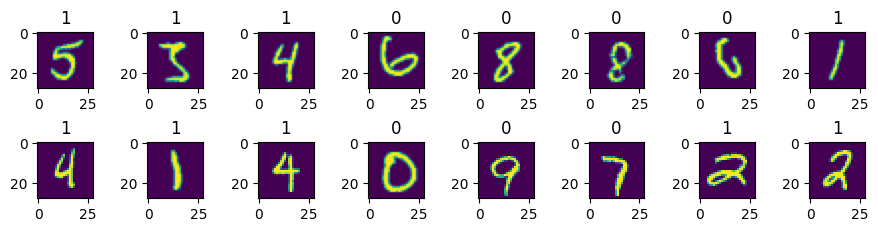

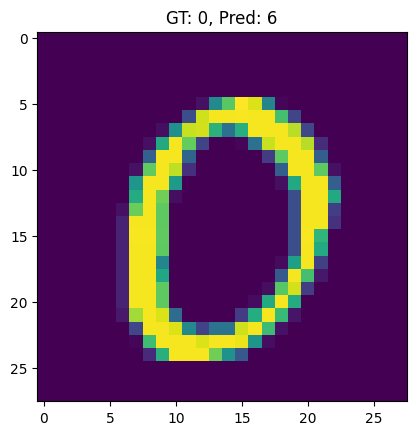

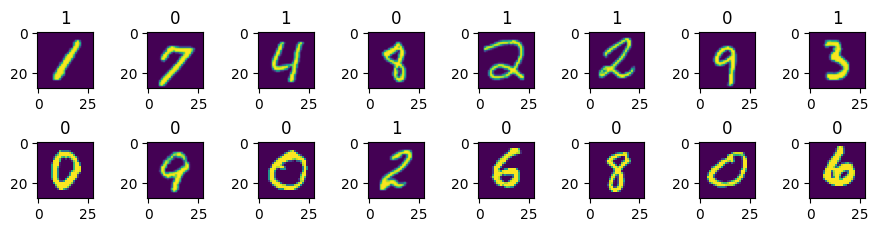

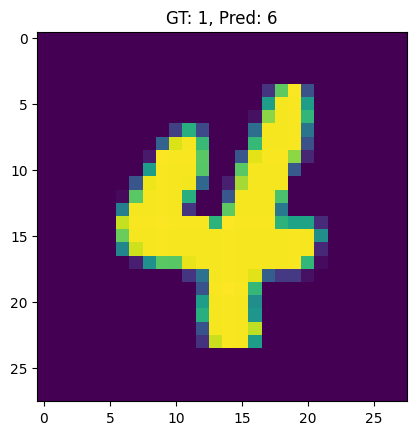

In [23]:
start_task = 200
num_tasks_to_plot = 10

for task_i in range(num_tasks_to_plot):
    sample_idx = (task_i + start_task) * (sequence_length - 1) + sequence_length - 2
    imgs, outputs, query, label = test_dataset[sample_idx]

    nrows = 2
    ncols = context_len // nrows
    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=set_size(doc_width_pt, 0.85, (nrows, ncols), False),
        layout="constrained",
    )

    for idx, (img, output) in enumerate(zip(imgs, outputs)):
        axes[idx // ncols, idx % ncols].imshow(img)
        axes[idx // ncols, idx % ncols].set_title(np.argmax(output))
    plt.show()
    plt.close()

    plt.imshow(query.numpy()[0])
    plt.title("GT: {}, Pred: {}".format(np.argmax(label), all_preds[sample_idx]))
    plt.show()
    plt.close()


In [24]:
assert 0

AssertionError: 

# Check Latent

In [ ]:
def get_latent(params, inputs, carries):
    cnn_outs, cnn_states = CNNModule(
        config.model_config.features,
        config.model_config.kernel_sizes,
        get_activation(CONST_RELU),
    ).apply(
        {"params": params[CONST_MODEL_DICT][CONST_MODEL][CONST_CNN][CONST_PARAMS]},
        inputs,
        capture_intermediates=True,
        mutable=["cnn_latents"]
    )

    cnn_outs = cnn_outs.reshape((len(cnn_outs), -1))

    _, mlp_states = MLPModule(
        config.model_config.layers,
        get_activation(CONST_RELU),
        get_activation(CONST_IDENTITY),
    ).apply(
        {"params": params[CONST_MODEL_DICT][CONST_MODEL][CONST_MLP][CONST_PARAMS]},
        cnn_outs,
        capture_intermediates=True,
        mutable=["mlp_latents"]
    )

    latents = OrderedDict()
    for (states, key) in [
        (cnn_states, "cnn_latents"),
        (mlp_states, "mlp_latents"),
    ]:
        for state, state_val in states[key].items():
            latents[state] = state_val
    return latents

In [ ]:
def plot(mlp_1_latents, labels, step):
    os.makedirs("./imgs/{}".format(exp_name), exist_ok=True)
    nrows = 1
    ncols = 2
    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=set_size(doc_width_pt, 0.95, (nrows, ncols), False),
        layout="constrained",
    )

    unique_classes = np.unique(labels["train"])

    for ax_i, key in enumerate(("train", "test")):
        for class_i in unique_classes:
            class_idxes = np.where(labels[key] == class_i)[0]
            axes[ax_i].scatter(
                mlp_1_latents[key][class_idxes, 0],
                mlp_1_latents[key][class_idxes, 1],
                label="Class {}".format(class_i) if ax_i == 0 else "",
                alpha=0.5,
                s=1
            )
        axes[ax_i].set_title(key)
    fig.legend()
    fig.suptitle("Model @ epoch {}".format(step))
    fig.tight_layout()
    plt.savefig("./imgs/{}/nc-step_{:08d}.png".format(exp_name, step), format="png", bbox_inches="tight", dpi=600)
    plt.close()

In [ ]:
batch_size = 300
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
)

In [ ]:
results = {}
for (step, params) in all_params:
    mlp_1_latents = {
        "train": [],
        "test": [],
    }
    labels = {
        "train": [],
        "test": [], 
    }
    all_latents = {
        "train": {},
        "test": {}
    }

    for key, dataloader in (("train", train_dataloader), ("test", test_dataloader)):
        for batch_i, (inputs, carries, outputs, _) in enumerate(iter(dataloader)):
            latents = get_latent(params, inputs, carries)
            mlp_1_latents[key].append(latents["mlp_{}".format(len(config.model_config.layers) - 1)][0])
            labels[key].append(outputs)
            for k in latents:
                all_latents[key].setdefault(k, [])
                all_latents[key][k].append(latents[k][0])

        mlp_1_latents[key] = np.concatenate(mlp_1_latents[key], axis=0)
        labels[key] = np.concatenate(labels[key], axis=0)
        all_latents[key] = {k: np.concatenate(all_latents[key][k]) for k in all_latents[key]}
    plot(mlp_1_latents, labels, step)
    results[step] = {
        "latents": all_latents,
        "labels": labels,
    }

In [ ]:
import imageio

with imageio.get_writer("./nc-{}.gif".format(exp_name), mode='I', duration=100) as writer:
    img_dir = "./imgs/{}".format(exp_name)
    for filename in sorted(os.listdir(img_dir)):
        if not filename.startswith("nc-step"):
            continue
        image = imageio.imread(os.path.join(img_dir, filename))
        writer.append_data(image)

# Check Neural Collapse Properties

In [ ]:
nc_results = {}
for step, step_res in results.items():
    valid_classes = np.unique(step_res["labels"]["train"])
    nc_results.setdefault(step, {})
    # for phase, phase_latents in step_res["latents"].items():
    for phase in ["train"]:
        phase_latents = step_res["latents"][phase]
        for layer, curr_latents in phase_latents.items():
            if layer.startswith("cnn"):
                continue
            nc_results[step].setdefault(layer, {})
            nc_results[step][layer]["global_means"] = np.mean(curr_latents, axis=0)
            offset = (curr_latents - nc_results[step][layer]["global_means"][None])[..., None]
            nc_results[step][layer]["train_total_cov"] = np.mean(offset @ np.transpose(offset, (0, 2, 1)), axis=0)

            nc_results[step][layer]["class_means"] = {}
            for class_i in valid_classes:
                class_idxes = np.where(step_res["labels"][phase] == class_i)[0]
                nc_results[step][layer]["class_means"][class_i] = np.mean(curr_latents[class_idxes], axis=0)
            between_class_offset = np.vstack([nc_results[step][layer]["class_means"][class_i] - nc_results[step][layer]["global_means"] for class_i in valid_classes])[..., None]
            nc_results[step][layer]["between_class_cov"] = np.mean(between_class_offset @ np.transpose(between_class_offset, (0, 2, 1)), axis=0)
            nc_results[step][layer]["within_class_cov"] = np.mean(
                np.concatenate(
                    [curr_latents[np.where(step_res["labels"][phase] == class_i)[0]] - nc_results[step][layer]["class_means"][class_i][None] for class_i in valid_classes],
                    axis=0
                ),
                axis=0
            )
            

In [ ]:
jax.tree_map(lambda x: x.shape, nc_results[step])

## NC1

In [ ]:
nrows = len(nc_results[1])
ncols = 1
fig, axes = plt.subplots(
    nrows,
    ncols,
    figsize=set_size(doc_width_pt, 0.95, (nrows, ncols), False),
    layout="constrained",
)


for ax_i, layer in enumerate(nc_results[1]):
    within_class_cov = np.array([nc_results[step][layer]["within_class_cov"] for step in nc_results])
    for dim_i in range(within_class_cov.shape[1]):
        axes[ax_i].plot(
            nc_results.keys(),
            within_class_cov[:, dim_i],
            label="dim. {}".format(dim_i)
        )
    axes[ax_i].set_title(layer)
    axes[ax_i].legend()
fig.suptitle("NC 1 Condition")
plt.show()
plt.close()